In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from typing import Tuple, Union
import math
import gdown
import mediapipe as mp
from keras import backend as K
import sys
print(sys.executable)

d:\Code-Projects\University\Fall2023\Grad\LipNet-Assistive-AI\.conda\python.exe


# 1. Build Data Loading Functions

In [2]:
# pixels
MARGIN = 0
ROW_SIZE = 0
FONT_SIZE = 1
FONT_THICKNESS = 1

# Input model Image size
IMAGE_SIZE = (50, 100)

batch_size = 1
mp_face_mesh =  mp.solutions.face_mesh.FaceMesh(max_num_faces=1,static_image_mode=True, min_detection_confidence=0.2)


## Functions

In [3]:
def normalized_to_pixel_coordinates(normalized_x, normalized_y, image_width, image_height):
    """Converts normalized values to pixel coordinates."""
    x_px = min(max(int(normalized_x * image_width), 0), image_width)
    y_px = min(max(int(normalized_y * image_height), 0), image_height)
    return x_px, y_px

In [4]:
def contrast_based_histogram_equalization_rgb(image):
    # Convert the image to uint8 if not already
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Split channels
    channels = cv2.split(image)

    # Apply histogram equalization to each channel
    equalized_channels = [cv2.equalizeHist(channel) for channel in channels]

    # Merge channels
    equalized_image = cv2.merge(equalized_channels)

    # Convert back to float between 0 and 1
    equalized_image = equalized_image / 255.0

    return equalized_image

In [5]:
import cv2
import mediapipe as mp


def use_camera():
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

    # Face detector model
    # mp_face_detection = mp.solutions.face_detection


    while True:

        ret, frame = cap.read()

        if not ret:
            print("Broken image")
            continue

        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Get the keypoints of each point of a face in the frame
        face_mesh_result = mp_face_mesh.process(frame_rgb)

        if face_mesh_result.multi_face_landmarks:
            for face_landmarks in face_mesh_result.multi_face_landmarks:
                
                image_rows, image_cols, _ = frame.shape

                try:
                    left = face_landmarks.landmark[214]
                    bottom= face_landmarks.landmark[200]
                    top = face_landmarks.landmark[164]
                    right = face_landmarks.landmark[434]

                    bottom_px = normalized_to_pixel_coordinates(bottom.x, bottom.y, image_cols, image_rows)
                    left_px = normalized_to_pixel_coordinates(left.x, left.y, image_cols, image_rows)
                    top_px = normalized_to_pixel_coordinates(top.x, top.y, image_cols, image_rows)
                    right_px = normalized_to_pixel_coordinates(right.x, right.y, image_cols, image_rows)

                    frame = frame[
                            top_px[1] : bottom_px[1],
                            left_px[0] : right_px[0],
                            :,
                        ]
                    
                    frame = cv2.resize(
                        frame, (IMAGE_SIZE[1],IMAGE_SIZE[0]), interpolation=cv2.INTER_LANCZOS4
                    )
                
                    
                    frame = contrast_based_histogram_equalization_rgb(frame)
                    
                    mean_value = np.mean(frame)
                    std_dev = np.std(frame)
                    frame = (frame - mean_value) / std_dev
                    
                    cv2.imshow("frame", frame)
                    
                except Exception as e:
                    # Handle the case where the landmarks are not found
                    print(e)
                    break

        # Display the frame

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

In [6]:
# use_camera()

In [8]:
import cv2
import mediapipe as mp
import numpy as np

def use_camera():
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

    # Face mesh model
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5)

    with face_mesh as face_mesh:
        while True:
            ret, frame = cap.read()

            if not ret:
                print("Broken image")
                continue

            # Convert to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Get face mesh landmarks
            results = face_mesh.process(frame_rgb)

            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    image_rows, image_cols, _ = frame.shape
                    # Define the text and font properties
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    font_scale = 1
                    font_color = (255, 255, 255)  # white color in BGR
                    thickness = 2
                    text =""
                    # Get the size of the text to determine the position
                    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
                    text_width, text_height = text_size
                    text_x = int((frame.shape[1] - text_width) / 2)
                    text_y = int((frame.shape[0] + text_height) / 2)

                    # Put the text on the frame

                    left_lip = face_landmarks.landmark[62]
                    right_lip = face_landmarks.landmark[292]

                    
                   
                    left_lip = normalized_to_pixel_coordinates(left_lip.x, left_lip.y, image_cols, image_rows)
                    right_lip = normalized_to_pixel_coordinates(right_lip.x, right_lip.y, image_cols, image_rows)

                    midpoint = [(left_lip[0]+right_lip[0])//2,(left_lip[1]+right_lip[1])//2]

                    m  = (right_lip[1]-left_lip[1])/(right_lip[0]-left_lip[0])
                    x = normalized_to_pixel_coordinates(1,1, image_cols, image_rows)[0]
                    b = midpoint[1]

                    y = (x*m)+b

                    midpoint_right = [normalized_to_pixel_coordinates(1,0.5, image_cols, image_rows)[0],int(y)]
                    # y= mx + b
                    #  = slope of ( left lip, right lip ) * lenght of frame + 0


                    # cv2.circle(frame, bottom_px, 5, (0, 255, 0), -1)  # Draw a green circle at the landmark

                    # cv2.circle(frame, left_px, 5, (0, 255, 0), -1)  # Draw a green circle at the landmark

                    # cv2.circle(frame, top_px, 5, (0, 255, 0), -1)  # Draw a green circle at the landmark

                    # cv2.circle(frame, right_px, 5, (0, 255, 0), -1)  # Draw a green circle at the landmark

                    # cv2.circle(frame, bottom_px, 5, (0, 255, 0), -1)  # Draw a green circle at the landmark
                    cv2.circle(frame, left_lip, 5, (0, 255, 0), -1)  # Draw a green circle at the landmark
                    # cv2.circle(frame, top_px, 5, (0, 255, 0), -1)  # Draw a green circle at the landmark
                    cv2.circle(frame, right_lip, 5, (0, 255, 0), -1)  # Draw a green circle at the landmark
                    cv2.circle(frame, midpoint, 5, (0, 150, 0), -1)  # Draw a green circle at the landmark
                    cv2.circle(frame, midpoint_right, 5, (0, 150, 0), -1)  # Draw a green circle at the landmark

                    # Calculate the differences in x and y coordinates
                    dx = right_lip[0] - midpoint_right[0]
                    dy = right_lip[1] - midpoint_right[1]
                    
                    # Calculate the angle using arctan(dy/dx)
                    angle_radians = math.atan2(dy, dx)
                    
                    # Convert radians to degrees
                    angle_degrees = math.degrees(angle_radians)
                    # angle_degrees -= 180
                    if angle_degrees >0:
                        angle_degrees = angle_degrees - 180
                    elif angle_degrees <0:
                        angle_degrees =  angle_degrees + 180

                    # Ensure angle is between 0 and 360 degrees
                    # if angle_degrees < 0:
                    #     angle_degrees += 360


                    # center = (image_rows/2,image_cols/2)
                    
                    # # # Rotate the image
                    rotation_matrix = cv2.getRotationMatrix2D(midpoint, angle_degrees, 1.0)
                    frame = cv2.warpAffine(frame, rotation_matrix, (normalized_to_pixel_coordinates(1,1, image_cols, image_rows)))
                
                    results = face_mesh.process(frame_rgb).multi_face_landmarks
                    for face_landmarks in results:
                        left = face_landmarks.landmark[214]
                        bottom= face_landmarks.landmark[200]
                        top = face_landmarks.landmark[164]
                        right = face_landmarks.landmark[434]
                        bottom_px = normalized_to_pixel_coordinates(bottom.x, bottom.y, image_cols, image_rows)
                        left_px = normalized_to_pixel_coordinates(left.x, left.y, image_cols, image_rows)
                        top_px = normalized_to_pixel_coordinates(top.x, top.y, image_cols, image_rows)
                        right_px = normalized_to_pixel_coordinates(right.x, right.y, image_cols, image_rows)

                        frame = frame[
                                top_px[1] : bottom_px[1],
                                left_px[0] : right_px[0],
                                :,
                            ]
                        break
                    # print(bottom_px,left_px,top_px,right_px)
                    # cv2.putText(frame, str(m), (text_x, text_y), font, font_scale, font_color, thickness)
                    # cv2.putText(frame, str(x), (text_x, text_y+40), font, font_scale, font_color, thickness)
                    # cv2.putText(frame, str(b), (text_x, text_y+80), font, font_scale, font_color, thickness)
                    # cv2.putText(frame, str(y), (text_x, text_y+120), font, font_scale, font_color, thickness)
                    cv2.putText(frame, str(angle_degrees), (text_x, text_y+160), font, font_scale, font_color, thickness)
                    break

            # Display the frame
            cv2.imshow("frame", frame)
            
            
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

    cap.release()
    cv2.destroyAllWindows()

use_camera()


In [11]:
video_dir = os.listdir(r"data\me\me")
alignments_dir = os.listdir(r"data\me\alignments")

In [6]:
def get_max_letters():
    max_letters = []
    for i in alignments_dir:
        with open("data\me\\alignments\\"+i, "r") as f:
            lines = f.readlines()
        tokens = 0
        spaces = 0
        for line in lines:
            line = line.strip("\n")
            tokens += len(line)
            spaces += 1

        max_letters.append(tokens+spaces-1)
    return max(max_letters)

max_letters = get_max_letters()
max_letters

38

In [7]:
def get_max_frames():
    max_frames = []
    for i in video_dir:
        cap = cv2.VideoCapture(fr"data\me\me\{i}")
        max_frames.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
        cap.release()
    
    return max(max_frames)
max_frames = get_max_frames()
max_frames

103

In [8]:
def load_video(path: str) -> List[float]:
    # opens the video's path as a camera object
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # frames of the video
    frames = np.empty((max_frames, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    idx = 0


    # loop over all frames in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        # if _ == 0:
        #     continue
        try:
            ret, frame = cap.read()
            image_rows, image_cols, _ = frame.shape
            # convert to rgb
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # get the keypoints (x,y)s of each point of a face in the frame
            face_mesh_result = mp_face_mesh.process(frame)

            # loop over each face landmark ~ (nose (x,y) lips (x,y) and so one and a bounding box)
            if face_mesh_result.multi_face_landmarks:

                for face_landmarks in face_mesh_result.multi_face_landmarks:

                    left = face_landmarks.landmark[214]
                    bottom= face_landmarks.landmark[200]
                    top = face_landmarks.landmark[164]
                    right = face_landmarks.landmark[434]

                    bottom_px = normalized_to_pixel_coordinates(bottom.x, bottom.y, image_cols, image_rows)
                    left_px = normalized_to_pixel_coordinates(left.x, left.y, image_cols, image_rows)
                    top_px = normalized_to_pixel_coordinates(top.x, top.y, image_cols, image_rows)
                    right_px = normalized_to_pixel_coordinates(right.x, right.y, image_cols, image_rows)

                    frame = frame[
                            top_px[1] : bottom_px[1],
                            left_px[0] : right_px[0],
                            :,
                        ]

                    frame = cv2.resize(
                        frame, (IMAGE_SIZE[1],IMAGE_SIZE[0]), interpolation=cv2.INTER_LANCZOS4
                    )
                    
                    frame = contrast_based_histogram_equalization_rgb(frame)
                    
                    mean_value = np.mean(frame)
                    std_dev = np.std(frame)
                    frame = (frame - mean_value) / std_dev

                    frames[idx] = frame

                    idx += 1
                    break

        except Exception as e:
                # Handle the case where the landmarks are not found
            print(e)
    if idx < get_max_frames():
        for i in range(idx, max_frames):
            frames[i] = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1],3))

    cap.release()
    cv2.waitKey(0)

    # normalize on the scale of the video
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    normalized = tf.cast((frames - mean), tf.float32) / std
    return normalized


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


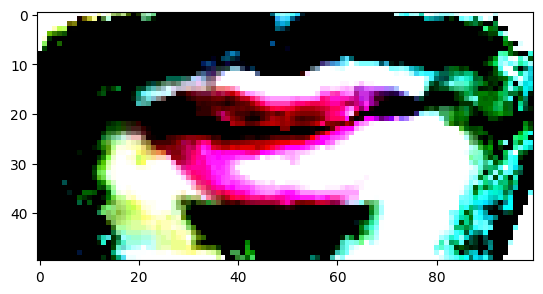

In [10]:
x = load_video(r'data\me\me\10 Galal.mp4')
plt.imshow(x[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


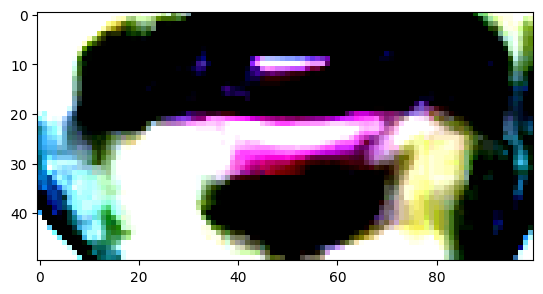

In [9]:
x = load_video(r'data\me\me\8 Galal.mp4')
plt.imshow(x[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


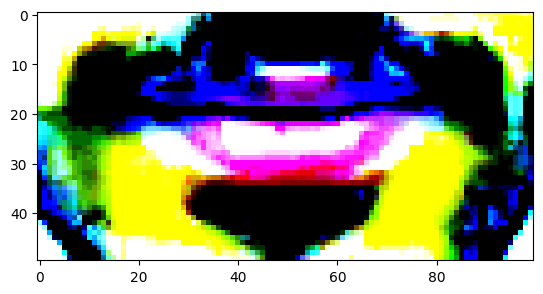

In [11]:
x = load_video(r'data\me\me\19 Galal.mp4')
plt.imshow(x[0])

In [27]:
x.shape

TensorShape([103, 50, 100, 3])

In [28]:
x.numpy().max(), x.numpy().min()

(2.6648374, -2.6191912)

In [16]:
vocab = [x for x in "ابتثجحخدذرزسشصضطظعغفقكلمنهويىء٠١٢٣٤٥٦٧٨٩ "]

In [17]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ى', 'ء', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', ' '] (size =42)


In [ ]:
char_to_num.get_vocabulary()

In [18]:
def char_to_arab(alignments):
    sub_arrays = []
    current_sub_array = []
    for element in num_to_char(alignments).numpy():
        if element.decode("utf-8") == "":
            if current_sub_array:  # Add a non-empty sub-array
                sub_arrays.append(current_sub_array)
            current_sub_array = []  # Start a new sub-array
        else:
            current_sub_array.append(element.decode("utf-8"))

    if current_sub_array:  # Add the last sub-array if it's not empty
        sub_arrays.append(current_sub_array)

    for i in sub_arrays:
        print(''.join(i),end=" ")

In [ ]:
char_to_num(["","ا", "ن", "ا", " ", "ا", "ن", "ا", ""])

In [ ]:
char_to_arab([1, 25, 1,0, 1, 25, 1])

In [19]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.strip("\n")
        tokens = [*tokens,' ',line]

    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
label = load_alignments(r"data\me\alignments\15 Galal.align")

In [20]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','me','me',f'{file_name}.mp4')
    alignment_path = os.path.join('data','me','alignments',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [ ]:
test_path = r'data\me\me\15 Galal.align'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
plt.imshow(frames[0],cmap='gray')

In [ ]:
alignments

In [ ]:
char_to_arab(alignments)

In [21]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [22]:
data = tf.data.Dataset.list_files("./data/me/me/*")

data = data.shuffle(500, reshuffle_each_iteration=False)

num_files = data.cardinality().numpy()

train_size = int(0.8 * num_files)
val_size = int(0.1 * num_files)
test_size = num_files - train_size - val_size

train_data = data.take(train_size)
val_test_data = data.skip(train_size)
val_data = val_test_data.take(val_size)
test_data = val_test_data.skip(val_size)


train_data = train_data.map(mappable_function)
train_data = train_data.padded_batch(
    batch_size, padded_shapes=([max_frames, None, None, None], [max_letters])
)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

val_data = val_data.map(mappable_function)
val_data = val_data.padded_batch(
    batch_size, padded_shapes=([max_frames, None, None, None], [max_letters])
)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(mappable_function)
test_data = test_data.padded_batch(
    batch_size, padded_shapes=([max_frames, None, None, None], [max_letters])
)
test_data = test_data.prefetch(tf.data.AUTOTUNE)


In [ ]:
char_to_num.vocabulary_size()

In [ ]:
frames, alignments = train_data.as_numpy_iterator().next()

In [ ]:
frames[0].shape

In [ ]:
sample = train_data.as_numpy_iterator()

In [ ]:
val = sample.next()

val[1][0].shape,val[0][0].shape

In [ ]:
val[0].shape

In [ ]:
val[1][0]

In [ ]:
char_to_arab(val[1][0])

# 3. Design the Deep Neural Network

In [1]:
from tensorflow.keras.models import Sequential ,model_from_json
from tensorflow.keras.layers import Conv3D,GRU, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
train_data.as_numpy_iterator().next()[0][0].shape

In [ ]:
char_to_num.vocabulary_size()

In [24]:
model = Sequential()
model.add(Conv3D(32,(1, 5, 5),strides=(1,2,2), input_shape=(max_frames, IMAGE_SIZE[0],IMAGE_SIZE[1], 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(64,(1, 5, 5), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(96,(1, 3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(GRU(256,kernel_initializer="Orthogonal", return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(256,kernel_initializer="Orthogonal", return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 103, 25, 50, 32)   2432      
                                                                 
 activation (Activation)     (None, 103, 25, 50, 32)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 103, 12, 25, 32)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 103, 12, 25, 64)   51264     
                                                                 
 activation_1 (Activation)   (None, 103, 12, 25, 64)   0         
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 103, 6, 12, 64)    0         
 g3D)                                                   

In [ ]:
yhat = model.predict(val[0])

In [ ]:
val[0].shape

In [ ]:
yhat.shape

In [ ]:
yhat[0].shape

In [ ]:
char_to_arab(tf.argmax(yhat[0], axis=1).numpy())

In [ ]:
model.input_shape

In [ ]:
model.output_shape

# 4. Setup Training Options and Train

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.sample = train_data.as_numpy_iterator().next()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.sample
        yhat = self.model.predict(data[0],verbose=0)  # [75,75]
        # yhat = yhat.reshape((yhat.shape[1],yhat.shape[2]))
        # print()
        # print()

        # print(yhat)
        decoded_200 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=200)[0][0].numpy()
        decoded_100 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=100)[0][0].numpy()
        decoded_50 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=50)[0][0].numpy()
        decoded_letter = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=char_to_num.vocabulary_size()+1)[0][0].numpy()
        decoded_40 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=40)[0][0].numpy()
        decoded_30 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=30)[0][0].numpy()
        decoded_20 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=20)[0][0].numpy()
        decoded_10 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=10)[0][0].numpy()
        decoded_5 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=5)[0][0].numpy()
        decoded_1 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=1)[0][0].numpy()
        decoded_1_greedy = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=True)[0][0].numpy()

        for x in range(len(yhat)):
            print("\n\n")
            print("Original:",tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode("utf-8"))
            print("Prediction Dec 200:",tf.strings.reduce_join(num_to_char(decoded_200[x])).numpy().decode("utf-8"))
            print("Prediction Dec 100:",tf.strings.reduce_join(num_to_char(decoded_100[x])).numpy().decode("utf-8"))
            print("Prediction Dec 50:",tf.strings.reduce_join(num_to_char(decoded_50[x])).numpy().decode("utf-8"))
            print("Prediction Dec Voc:",tf.strings.reduce_join(num_to_char(decoded_letter[x])).numpy().decode("utf-8"))
            print("Prediction Dec 40:",tf.strings.reduce_join(num_to_char(decoded_40[x])).numpy().decode("utf-8"))
            print("Prediction Dec 30:",tf.strings.reduce_join(num_to_char(decoded_30[x])).numpy().decode("utf-8"))
            print("Prediction Dec 20:",tf.strings.reduce_join(num_to_char(decoded_20[x])).numpy().decode("utf-8"))
            print("Prediction Dec 10:",tf.strings.reduce_join(num_to_char(decoded_10[x])).numpy().decode("utf-8"))
            print("Prediction Dec 5:",tf.strings.reduce_join(num_to_char(decoded_5[x])).numpy().decode("utf-8"))
            print("Prediction Dec 1:",tf.strings.reduce_join(num_to_char(decoded_1[x])).numpy().decode("utf-8"))
            print("Prediction Dec Greedy:",tf.strings.reduce_join(num_to_char(decoded_1_greedy[x])).numpy().decode("utf-8"))
            print("\n\n")

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('checkpoints','weights-{epoch:02d}-{val_loss:.2f}.hdf5'), monitor='val_loss', save_weights_only=True, save_best_only=True,mode='min',save_freq='epoch') 

In [ ]:
example_callback = ProduceExample(data)

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=500,
    callbacks=[
        example_callback,
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  # Change to the appropriate loss or metric
            patience=100,
            restore_best_weights=True,
        ),
        checkpoint_callback
    ],
    batch_size=batch_size,
)

In [23]:
for i in train_data.as_numpy_iterator():
    yhat = loaded_model.predict(i[0],verbose=0)
    decoded_200 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=200)[0][0].numpy()
    # decoded_100 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=100)[0][0].numpy()
    # decoded_50 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=50)[0][0].numpy()
    # decoded_letter = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=char_to_num.vocabulary_size()+1)[0][0].numpy()
    # decoded_40 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=40)[0][0].numpy()
    # decoded_30 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=30)[0][0].numpy()
    # decoded_20 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=20)[0][0].numpy()
    # decoded_10 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=10)[0][0].numpy()
    # decoded_5 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=5)[0][0].numpy()
    # decoded_1 = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=False,beam_width=1)[0][0].numpy()
    # decoded_1_greedy = tf.keras.backend.ctc_decode(yhat, [max_frames], greedy=True)[0][0].numpy()

    for x in range(len(yhat)):
        print("\n\n")
        print("Original:",tf.strings.reduce_join(num_to_char(i[1][x])).numpy().decode("utf-8"))
        print("Prediction Dec 200:",tf.strings.reduce_join(num_to_char(decoded_200[x])).numpy().decode("utf-8"))
        # print("Prediction Dec 100:",tf.strings.reduce_join(num_to_char(decoded_100[x])).numpy().decode("utf-8"))
        # print("Prediction Dec 50:",tf.strings.reduce_join(num_to_char(decoded_50[x])).numpy().decode("utf-8"))
        # print("Prediction Dec Voc:",tf.strings.reduce_join(num_to_char(decoded_letter[x])).numpy().decode("utf-8"))
        # print("Prediction Dec 40:",tf.strings.reduce_join(num_to_char(decoded_40[x])).numpy().decode("utf-8"))
        # print("Prediction Dec 30:",tf.strings.reduce_join(num_to_char(decoded_30[x])).numpy().decode("utf-8"))
        # print("Prediction Dec 20:",tf.strings.reduce_join(num_to_char(decoded_20[x])).numpy().decode("utf-8"))
        # print("Prediction Dec 10:",tf.strings.reduce_join(num_to_char(decoded_10[x])).numpy().decode("utf-8"))
        # print("Prediction Dec 5:",tf.strings.reduce_join(num_to_char(decoded_5[x])).numpy().decode("utf-8"))
        # print("Prediction Dec 1:",tf.strings.reduce_join(num_to_char(decoded_1[x])).numpy().decode("utf-8"))
        # print("Prediction Dec Greedy:",tf.strings.reduce_join(num_to_char(decoded_1_greedy[x])).numpy().decode("utf-8"))
        print("\n\n")

C:\Users\Mgala\AppData\Roaming\Python\Python39\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '





Original: عامل ايه انت كويس
Prediction Dec 200: عامل ايه انت كويس






Original: انا مش بسمع
Prediction Dec 200: انا مش بسمع






Original: فين الحمام لو سمحت
Prediction Dec 200: فين الحمام لو سمحت






Original: هتعمل ايه النهردا
Prediction Dec 200: هتعمل ايه النهردا






Original: اسمى محمد جلال و عندى واحد و عشرين سنه
Prediction Dec 200: اسمى محمد جلال و عندى واحد و عشرين سنه






Original: انا مش بشوف
Prediction Dec 200: انا مش بشوف






Original: انا مش بكلم للاسف
Prediction Dec 200: انا مش بكلم لاسف






Original: انا الحمد لله كويس
Prediction Dec 200: انا الحمد له كويس






Original: انا كويس
Prediction Dec 200: انا كويس






Original: انت اسمك ايه
Prediction Dec 200: انت اسمك ايه






Original: واحد اتنين تالاته
Prediction Dec 200: واحد اتنين تالاته






Original: انا عطشان
Prediction Dec 200: انا عطشان






Original: بعد اذنك انا عايز اعدى
Prediction Dec 200: بعد اذنك انا عايز اعدى






Original: انا جعان
Prediction Dec 200: انا جعان






Original: عندك كام سن

In [ ]:
model_json = model.to_json()
with open("models\model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("models\galal_22.h5")

In [3]:
with open('models\galal_22.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("models\galal_22.h5")

In [ ]:
plt.plot(history.history['loss'])

# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
labels = """عامل ايه انت كويس
عملت ايه النهردا
انت رايح فين دلوئتي
هتعمل ايه النهردا
واحد اتنين تالاته
سته خمسه اربعه
سبعه تمنيه تسعه عشره
انت كويس
انا كويس
انا جعان
انا عطشان
انا مش بسمع
انا مش بشوف
عندك كام سنه
انا مش بكلم للاسف
بعد اذنك انا عايز اعدى
انت اسمك ايه
انا الحمد لله كويس
فين الحمام لو سمحت
ممكن تتكلم بسرعه
ممكن تتكلم براحه
الساعه كام لو سمحت
الجو ساقع جدا النهردا
انا تعبان جدا للاسف
انا محتاج فلوس دلوقتي
ممكن نخرج دلوقتي
بقولك ايه يا باشا
انا عايز اشتري حاجات
واحشتنى ايه اخبارك
الطريق زحمه و واقف
تحب تشرب حاجه
السلام عليكم دا بكام
شكرا ساعدنى حالن
اتفضل جوا خد راحتك
انا اسف على سوء التفاهم
أنا سعيد انى شفتك بك
أنا معجب بشخصيتك
أنا أحترمك جدا
أنا أقدر اساعدك
أنا آسف على التأخير
أنا ممتن لاهتمامك
أنا عايز اسمع اكتر
أنا  عايز اشتغل معك
أنا عازمك عندى فلبيت
الرحلة  لشرم الشيخ يوم الجمعة الساعة 10 صباحا
العرض المسرحي في المسرح القومي الساعة 8 مساء
الماتش في ملعب القاهرة الساعة 6 مساء
المعرض الفني في المتحف الوطني الساعة 11 صباحا"""
idx = 3
for line in labels.split("\n"):
    print(line)        
    for person in ["Galal"]:
        with open(fr"data\me\alignments\{idx} {person}.align","w") as writer:
            writer.write("\n".join(line.split()))
    idx +=1